In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler

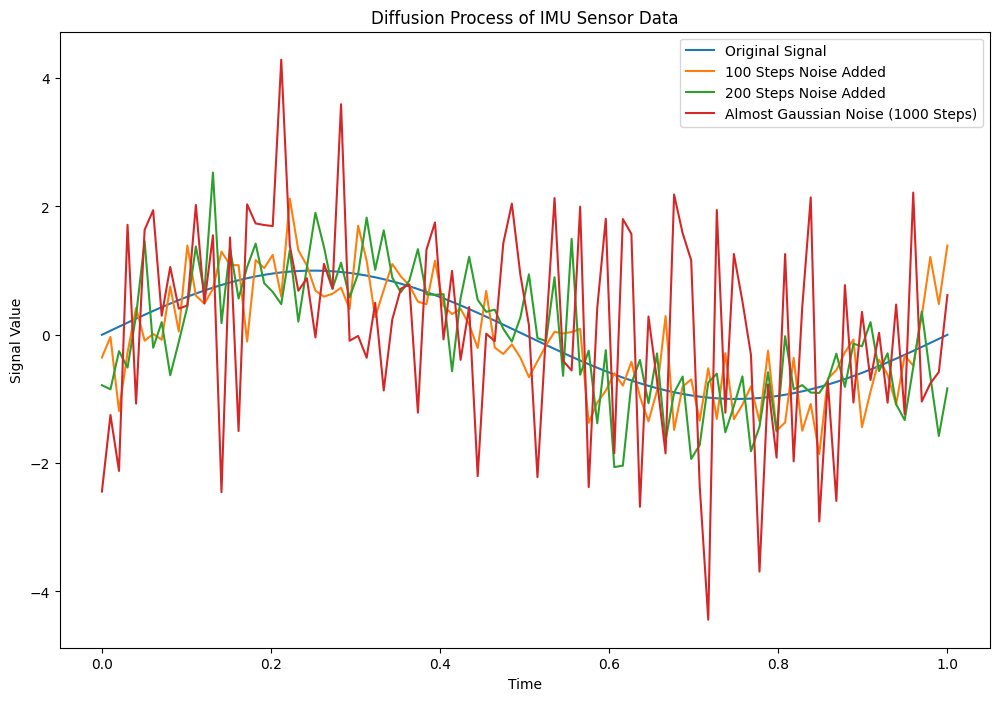

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Define the noise-adding function
def add_noise(signal, noise_scale):
    noise = np.random.normal(0, noise_scale, len(signal))
    return signal + noise

# Step 3: Perform diffusion process with specific steps
def diffusion_process(signal, num_steps, noise_scale):
    noisy_signal = signal.copy()
    for _ in range(num_steps):
        noisy_signal = add_noise(noisy_signal, noise_scale)
    return noisy_signal

# Visualization
if __name__ == "__main__":
    # Original signal is provided externally
    # original_signal = np.sin(2 * np.pi * np.linspace(0, 1, 100))  # Example placeholder signal
    original_signal = data_all[100,:,0]
    
    time = np.linspace(0, 1, len(original_signal))

    # Diffusion process for different steps
    noise_scale = 0.05  # Scale of added noise
    signal_100_steps = diffusion_process(original_signal, 100, noise_scale)
    signal_200_steps = diffusion_process(original_signal, 200, noise_scale)
    almost_gaussian_signal = diffusion_process(original_signal, 1000, noise_scale)

    # Plot the signals
    plt.figure(figsize=(12, 8))
    plt.plot(time, original_signal, label="Original Signal")
    plt.plot(time, signal_100_steps, label="100 Steps Noise Added")
    plt.plot(time, signal_200_steps, label="200 Steps Noise Added")
    plt.plot(time, almost_gaussian_signal, label="Almost Gaussian Noise (1000 Steps)")

    plt.title("Diffusion Process of IMU Sensor Data")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.show()


In [6]:
data_path = '../Datas/uschad_activity_dataset.h5'

In [66]:
activity_label = 'walkingleft'
window = 1000
step = 200

with h5py.File(data_path, 'r') as f_r:
    # data_genbylabel = f_r['data_genbylabel_1000'][:]
    # # test_sample = data_genbylabel[100,:,1]
    # print(data_genbylabel.shape)
    
    running_data = f_r['datas'][activity_label][:]
    print(running_data.shape)
    
scaler = MinMaxScaler()
data_fitted = scaler.fit_transform(running_data)
window = 1000
step = 200

num_splits = int((data_fitted.shape[0] - window) / step) + 1
data_all = []

for i in range(num_splits):
    start = i * step
    end = start + window
    data_all.append(data_fitted[start:end, :])
    
data_all = np.array(data_all)
print(data_all.shape)

generated_data_path = f"../Experiments_1203_multilen/dsensor_{window}/{activity_label}_genbylabel.npy"

(258800, 6)
(1290, 1000, 6)


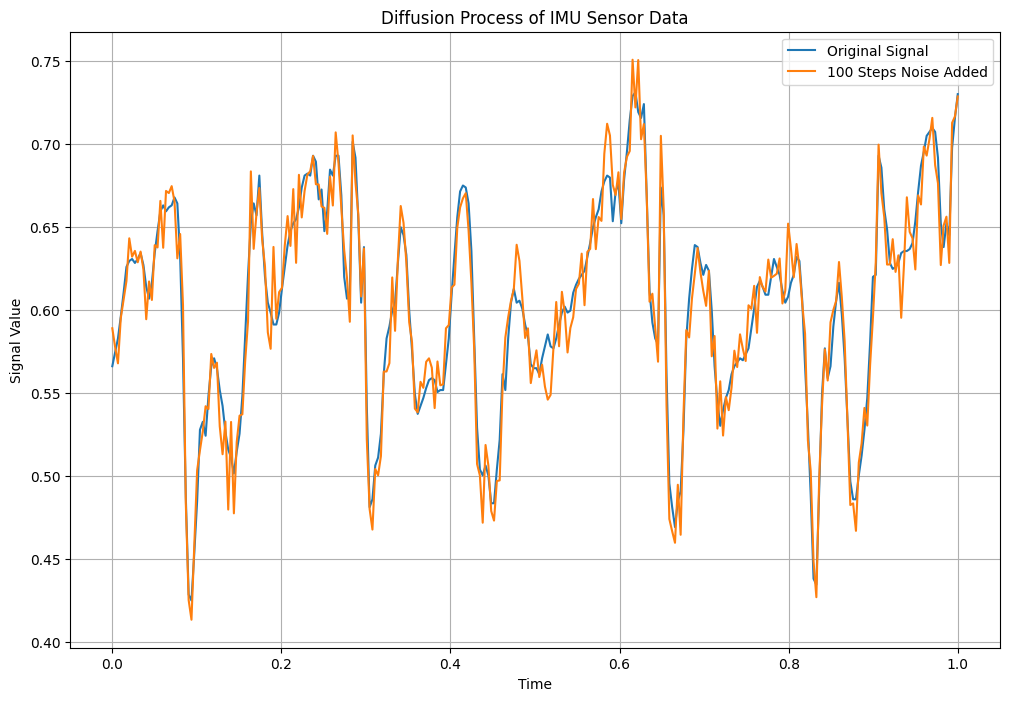

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Define the diffusion parameters
class Diffusion:
    def __init__(self, beta_start=0.0001, beta_end=0.02, num_steps=1000, device='cpu'):
        self.device = device
        self.num_steps = num_steps
        self.betas = torch.linspace(beta_start, beta_end, steps=self.num_steps + 1).to(self.device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def _extract(self, a: torch.FloatTensor, t: torch.LongTensor, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start: torch.FloatTensor, t: torch.LongTensor, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start).to(self.device)
        
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

# Visualization
if __name__ == "__main__":
    # Original signal is provided externally
    # original_signal = np.sin(2 * np.pi * np.linspace(0, 1, 100))  # Example placeholder signal
    
    original_signal = data_all[400,300:600,1]
    
    time = np.linspace(0, 1, len(original_signal))

    # Convert original signal to torch tensor
    original_signal_tensor = torch.tensor(original_signal, dtype=torch.float32).to('cpu')

    # Initialize diffusion model
    diffusion = Diffusion(num_steps=1000, device='cpu')

    # Generate noisy signals at different steps
    t_100 = torch.tensor([1], dtype=torch.long).to('cpu')
    t_200 = torch.tensor([10], dtype=torch.long).to('cpu')
    t_1000 = torch.tensor([100], dtype=torch.long).to('cpu')

    signal_100_steps = diffusion.q_sample(original_signal_tensor, t_100).numpy()
    signal_200_steps = diffusion.q_sample(original_signal_tensor, t_200).numpy()
    almost_gaussian_signal = diffusion.q_sample(original_signal_tensor, t_1000).numpy()

    # Plot the signals
    plt.figure(figsize=(12, 8))
    plt.plot(time, original_signal, label="Original Signal")
    plt.plot(time, signal_100_steps.flatten(), label="100 Steps Noise Added")
    # plt.plot(time, signal_200_steps.flatten(), label="200 Steps Noise Added")
    # plt.plot(time, almost_gaussian_signal.flatten(), label="Almost Gaussian Noise (1000 Steps)")

    plt.title("Diffusion Process of IMU Sensor Data")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend()
    plt.grid()
    plt.show()


(300, 6)


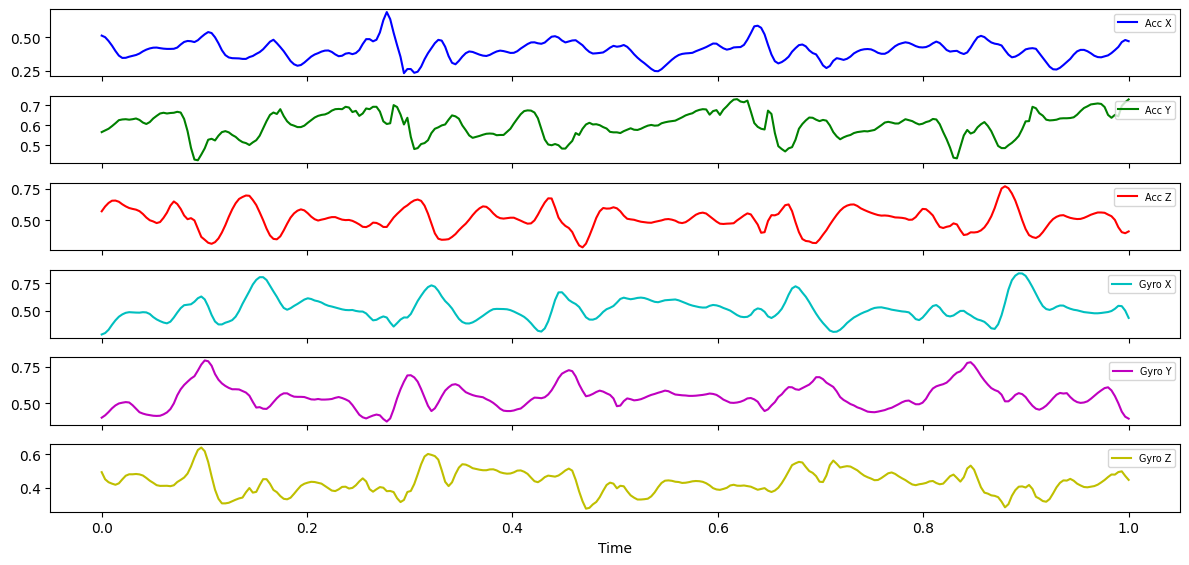

In [80]:
original_signal = data_all[400,300:600,:]
print(original_signal.shape)

# Plot each axis as a subplot
labels = ["Acc X", "Acc Y", "Acc Z", "Gyro X", "Gyro Y", "Gyro Z"]
colors = ["b", "g", "r", "c", "m", "y"]

fig, axs = plt.subplots(6, 1, figsize=(12, 6), sharex=True)
for i in range(6):
    axs[i].plot(time, original_signal[:, i], label=labels[i], color=colors[i])
    axs[i].legend(fontsize='x-small', loc='upper right')  # Smaller legend, placed on the right

axs[-1].set_xlabel("Time")
# plt.suptitle("IMU Sensor Data (6 Axes)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Draw the original data and generated data

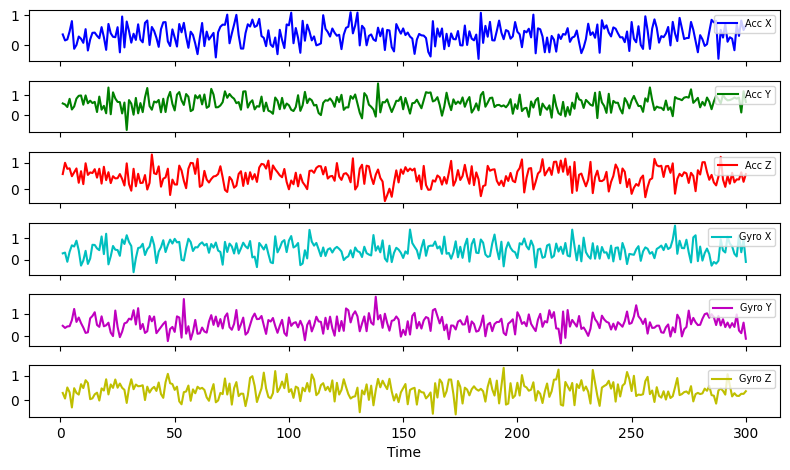

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Define the diffusion parameters
class Diffusion:
    def __init__(self, beta_start=0.0001, beta_end=0.02, num_steps=1000, device='cpu'):
        self.device = device
        self.num_steps = num_steps
        self.betas = torch.linspace(beta_start, beta_end, steps=self.num_steps + 1).to(self.device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def _extract(self, a: torch.FloatTensor, t: torch.LongTensor, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    def q_sample(self, x_start: torch.FloatTensor, t: torch.LongTensor, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start).to(self.device)
        
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

# Visualization
if __name__ == "__main__":
    # Original signal is provided externally
    original_signal = data_all[400,300:600,:]  # Example placeholder signal with 6 axes
    time = np.arange(1, 301)  # Time from 1 to 300

    # Initialize diffusion model
    diffusion = Diffusion(num_steps=1000, device='cpu')

    # Generate noisy signals for different steps
    t_1 = torch.tensor([1], dtype=torch.long).to('cpu')
    t_10 = torch.tensor([10], dtype=torch.long).to('cpu')
    t_100 = torch.tensor([100], dtype=torch.long).to('cpu')

    noisy_signals_1 = diffusion.q_sample(torch.tensor(original_signal, dtype=torch.float32), t_1).numpy()
    noisy_signals_10 = diffusion.q_sample(torch.tensor(original_signal, dtype=torch.float32), t_10).numpy()
    noisy_signals_100 = diffusion.q_sample(torch.tensor(original_signal, dtype=torch.float32), t_100).numpy()

    # Plot each axis with different noise levels
    labels = ["Acc X", "Acc Y", "Acc Z", "Gyro X", "Gyro Y", "Gyro Z"]
    colors = ["b", "g", "r", "c", "m", "y"]

    fig, axs = plt.subplots(6, 1, figsize=(8, 5), sharex=True)
    for i in range(6):
        # axs[i].plot(time, original_signal[:, i], label=f"{labels[i]}", color=colors[i])
        # axs[i].plot(time, noisy_signals_1[:, i], label=f"{labels[i]}", color=colors[i])
        # axs[i].plot(time, noisy_signals_10[:, i], label=f"{labels[i]}", color=colors[i])
        axs[i].plot(time, noisy_signals_100[:, i], label=f"{labels[i]}", color=colors[i])
        axs[i].legend(fontsize='x-small', loc='upper right')  # Smaller legend, placed on the right

    axs[-1].set_xlabel("Time")
    # plt.suptitle("IMU Sensor Data with Diffusion Noise (6 Axes)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


(878, 1000, 6)


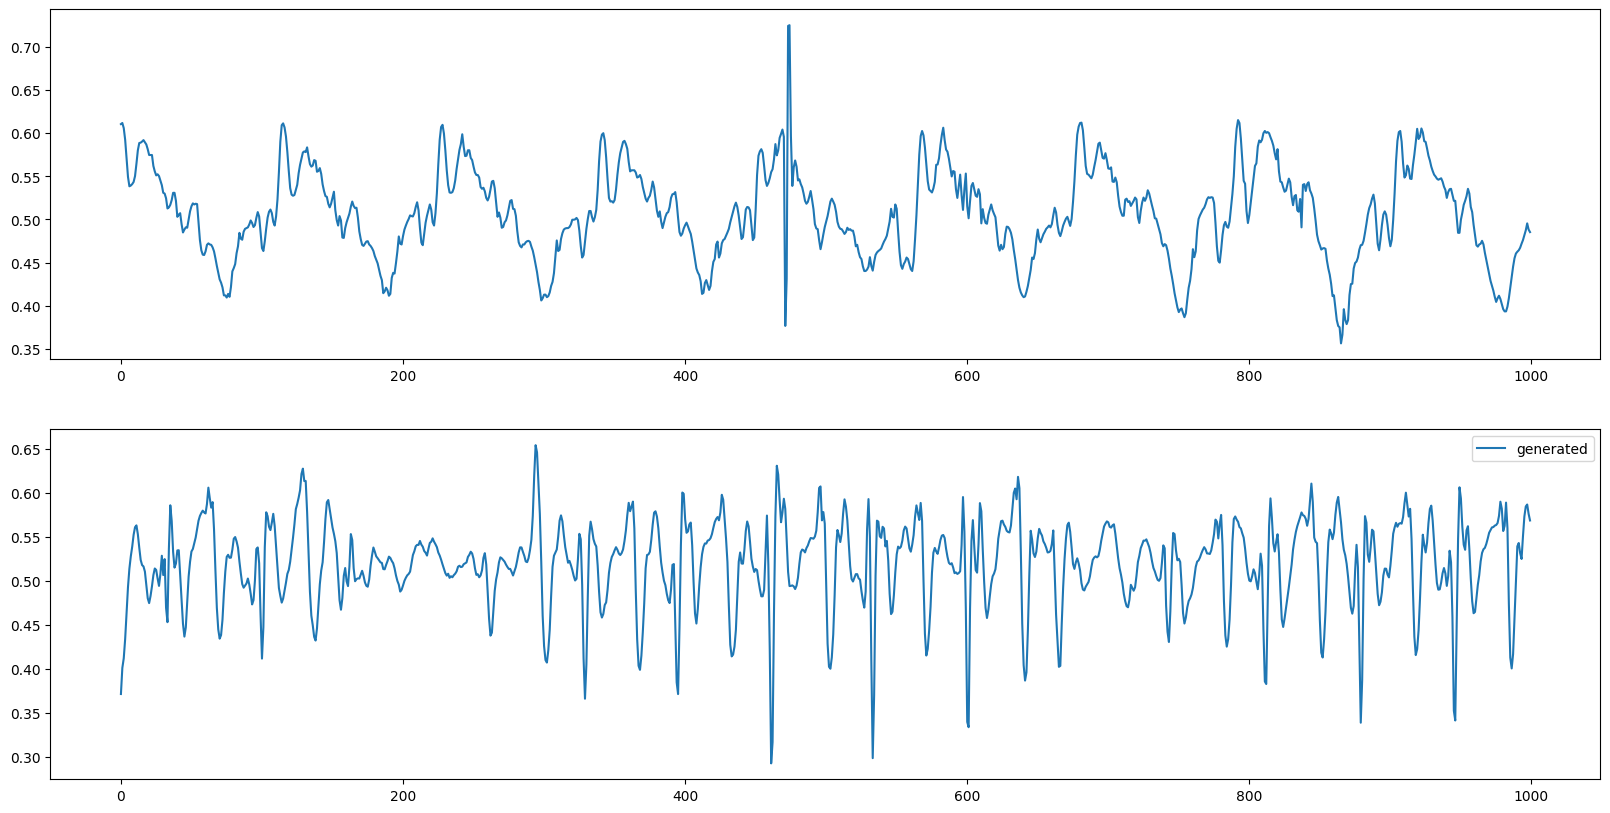

In [13]:
""" 
original data 
data_all
"""

generated_data_path = '../Experiments_1203_multilen/dsensor_1000/runningforward_genbylabel.npy'

generated_data = np.load(generated_data_path)
print(generated_data.shape)


sample_cnt = 200
var_idx = 3

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(data_all[sample_cnt,:,var_idx], label = 'original')

plt.subplot(2,1,2)
plt.plot(generated_data[sample_cnt,:,var_idx], label = 'generated')
plt.legend()



In [15]:
import pandas as pd
import numpy as np

# Parameters for fake data generation
scenes = list(range(1, 13))  # 12 scenes
methods = ['Method_A', 'Method_B', 'Method_C', 'Method_D', 'Method_E']
seq_lens = [100, 200, 300, 400, 500]
metrics = ['Context-FID', 'Correlation Score', 'Discriminative Score', 'Predictive Score']

# Create a fake dataset
data = []

np.random.seed(42)  # For reproducibility

for scene in scenes:
    for method in methods:
        for seq_len in seq_lens:
            # Generate fake scores for each metric
            context_fid = np.random.uniform(0.5, 1.0) + 0.01 * seq_len / 500 * (methods.index(method) + 1)
            correlation_score = np.random.uniform(0.7, 1.0) - 0.01 * seq_len / 500 * (methods.index(method) + 1)
            discriminative_score = np.random.uniform(0.5, 0.9) + 0.005 * seq_len / 500 * (methods.index(method) + 1)
            predictive_score = np.random.uniform(0.6, 1.0) - 0.005 * seq_len / 500 * (methods.index(method) + 1)
            
            data.append({
                'Scene': scene,
                'Method': method,
                'Seq_len': seq_len,
                'Context-FID': context_fid,
                'Correlation Score': correlation_score,
                'Discriminative Score': discriminative_score,
                'Predictive Score': predictive_score
            })

# Convert to DataFrame
fake_data = pd.DataFrame(data)

# Display the DataFrame to the user for verification
import ace_tools as tools; tools.display_dataframe_to_user(name="Fake Evaluation Metrics Dataset", dataframe=fake_data)

fake_data.head()


ModuleNotFoundError: No module named 'ace_tools'

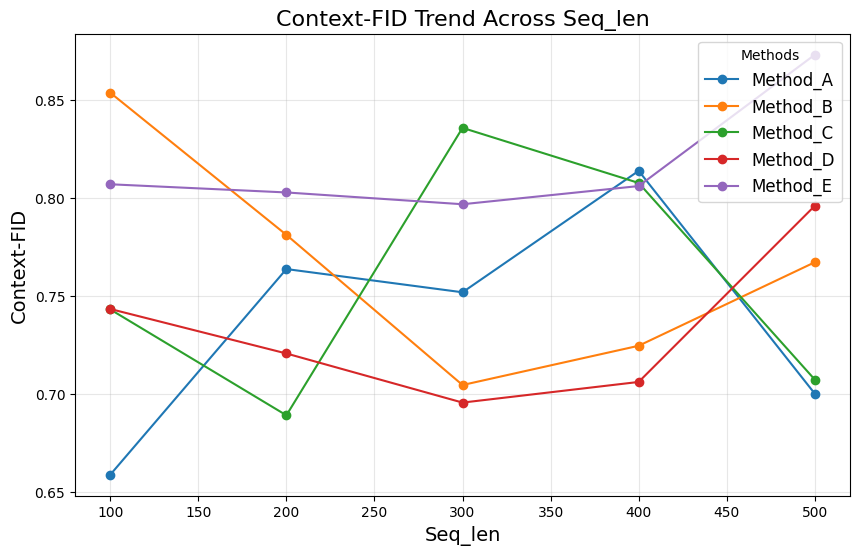

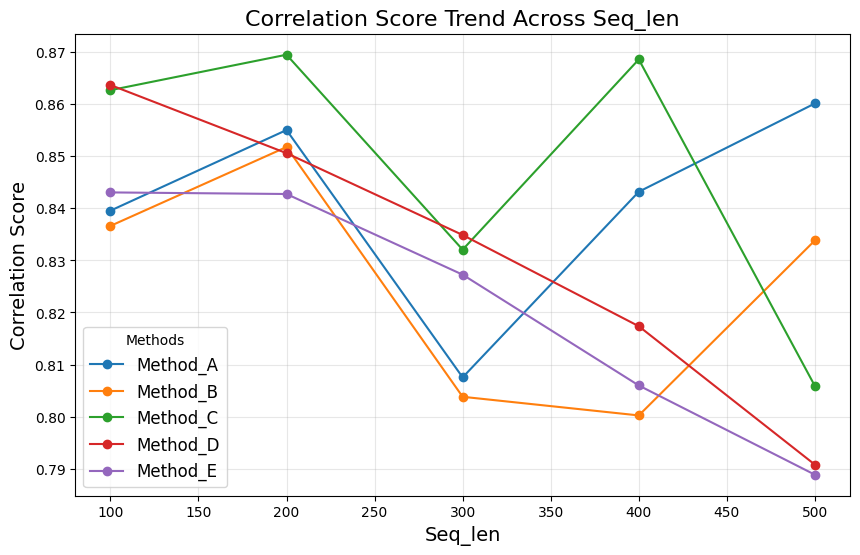

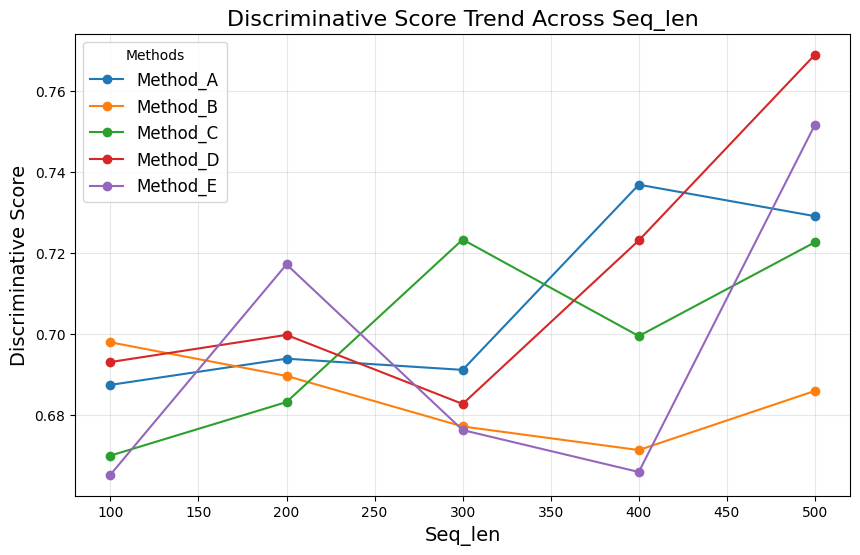

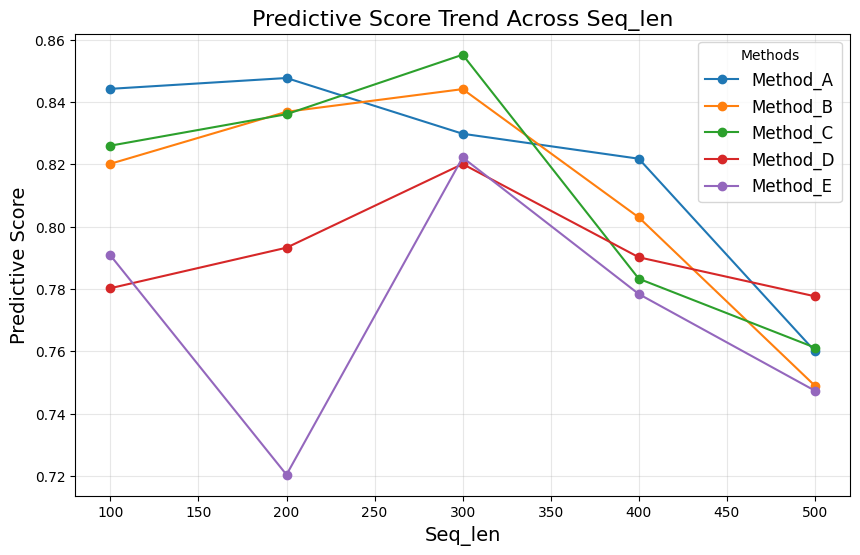

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# 加载数据
fake_data = pd.DataFrame(data)  # 假数据已经生成

# 确保列正确
metrics = ['Context-FID', 'Correlation Score', 'Discriminative Score', 'Predictive Score']
methods = fake_data['Method'].unique()
seq_lens = fake_data['Seq_len'].unique()

# 开始绘图
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for method in methods:
        method_data = fake_data[fake_data['Method'] == method]
        means = method_data.groupby('Seq_len')[metric].mean()
        plt.plot(seq_lens, means, label=method, marker='o')  # 曲线带点

    plt.title(f'{metric} Trend Across Seq_len', fontsize=16)
    plt.xlabel('Seq_len', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.legend(title='Methods', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# 示例数据
seq_lens = [100, 200, 300, 400, 500]
methods = ['Method_A', 'Method_B', 'Method_C', 'Method_D', 'Method_E']
metrics = ['Context-FID', 'Correlation Score', 'Discriminative Score', 'Predictive Score']

# 假设 data 是一个 pandas DataFrame，包含上述结构
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for method in methods:
        # 筛选方法对应的数据
        method_data = data[data['Method'] == method]
        plt.plot(seq_lens, method_data[metric], label=method, marker='o')
    
    plt.title(f'{metric} Trend Across Seq_len', fontsize=14)
    plt.xlabel('Seq_len', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(title='Methods')
    plt.grid(alpha=0.3)
    plt.show()


NameError: name 'data' is not defined

<Figure size 1000x600 with 0 Axes>

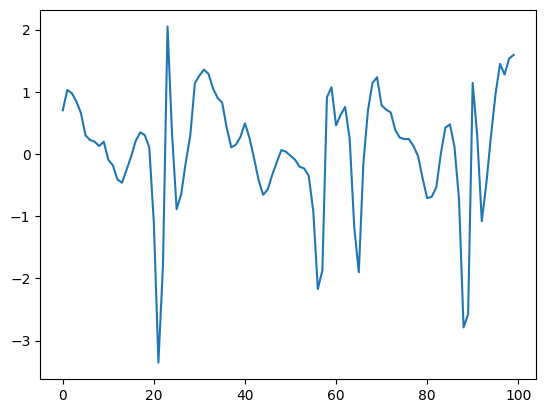

In [7]:
runningsample = running_data[100:200,1]
plt.plot(runningsample)

In [15]:
def norm_and_main_freq(x, k):
    print('check input shape', x.shape)
    # Apply FFT to get the frequency domain representation
    z = torch.fft.rfft(x, dim=2)
    # print('z shape', z.shape)
    
    # Find the top k largest magnitude frequency indices
    ks = torch.topk(z.abs(), k, dim=2)
    top_k_indices = ks.indices
    # print('check top k indices', top_k_indices.shape)
    
    # Create a mask for the top k frequencies
    mask = torch.zeros_like(z)
    mask.scatter_(2, top_k_indices, 1)  # Set top k frequency indices to 1
    
    # Apply mask to get the top k frequency components
    z_m = z * mask  # z_m contains only the top k frequency components
    
    # Get the remaining frequencies (by zeroing out the top k components)
    z_r = z * (1 - mask)  # z_r contains the remaining lower magnitude frequencies
    
    # Apply inverse FFT to bring the signals back to time domain
    x_m = torch.fft.irfft(z_m, dim=2).real  # Main frequency components
    x_r = torch.fft.irfft(z_r, dim=2).real  # Remaining part (without top k frequencies)
    
    # Return both components
    return x_r, x_m


In [21]:
input_tensor = torch.tensor(data_all[0:1000,:,:]).float().permute(0, 2, 1)
x_r, x_m = norm_and_main_freq(input_tensor, 3)
print(x_r.shape, x_m.shape)

check input shape torch.Size([1000, 6, 100])
torch.Size([1000, 6, 100]) torch.Size([1000, 6, 100])


In [22]:
x_m.shape

torch.Size([1000, 6, 100])

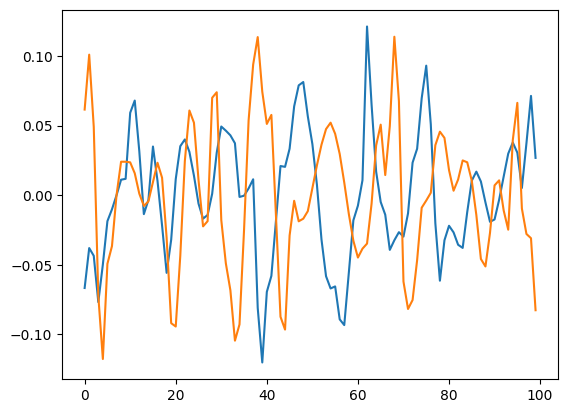

In [18]:

for i in range(40,42):
    plt.plot(x_r[i,5,:])
    # plt.plot(x_m[i,5,:])
    # plt.plot(data_all[i,:,5])
plt.show()

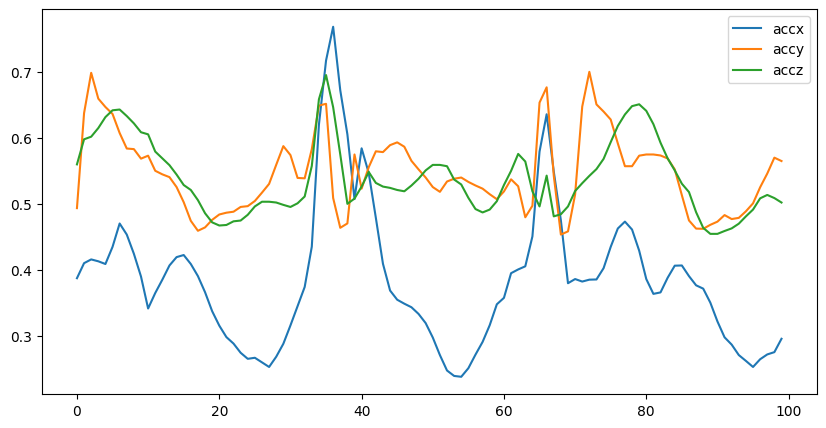

In [31]:
idx = 300
feature_id = 3
plt.figure(figsize=(10, 5))
# plt.plot(x_r[idx,0,:], label='resfreq_accx')
# plt.plot(x_r[idx,1,:], label='resfreq_accy')
# plt.plot(x_r[idx,2,:], label='resfreq_accz')

plt.plot(input_tensor[idx,0,:], label='accx')
plt.plot(input_tensor[idx,1,:], label='accy')
plt.plot(input_tensor[idx,2,:], label='accz')


# plt.plot(x_r[idx,feature_id,:], label='Remaining')
# plt.plot(x_m[idx,feature_id,:], label='Main')
# plt.plot(input_tensor[idx,feature_id,:], label='Original')
# plt.plot(x_r[idx,feature_id,:] + x_m[idx,feature_id,:], label='Reconstructed')
plt.legend()
plt.show()

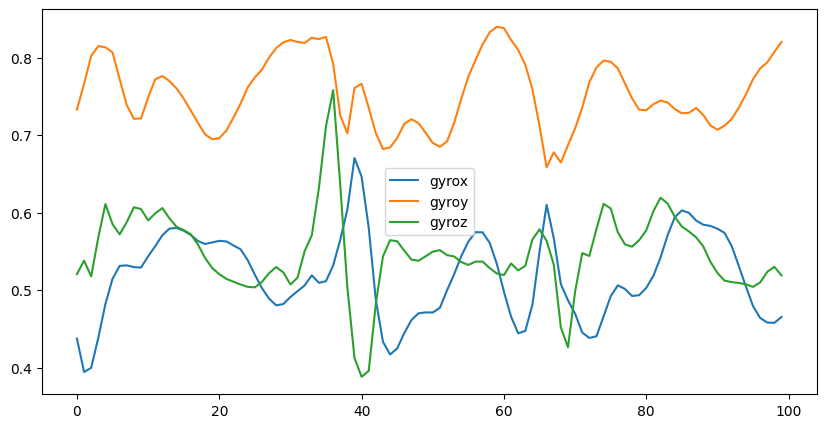

In [32]:
idx = 300
feature_id = 3
plt.figure(figsize=(10, 5))
# plt.plot(x_r[idx,3,:], label='resfreq_gyrox')
# plt.plot(x_r[idx,4,:], label='resfreq_gyroy')
# plt.plot(x_r[idx,5,:], label='resfreq_gyroz')

plt.plot(input_tensor[idx,3,:], label='gyrox')
plt.plot(input_tensor[idx,4,:], label='gyroy')
plt.plot(input_tensor[idx,5,:], label='gyroz')

# plt.plot(x_r[idx,feature_id,:], label='Remaining')
# plt.plot(x_m[idx,feature_id,:], label='Main')
# plt.plot(input_tensor[idx,feature_id,:], label='Original')
# plt.plot(x_r[idx,feature_id,:] + x_m[idx,feature_id,:], label='Reconstructed')
plt.legend()
plt.show()

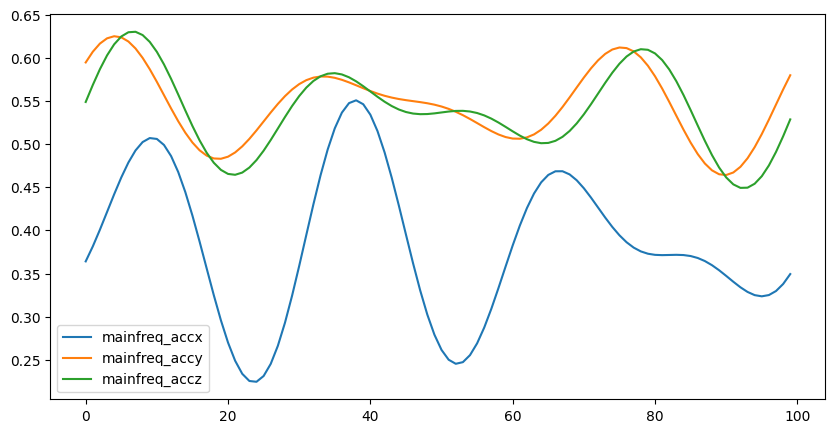

In [29]:
idx = 300
feature_id = 3
plt.figure(figsize=(10, 5))
plt.plot(x_m[idx,0,:], label='mainfreq_accx')
plt.plot(x_m[idx,1,:], label='mainfreq_accy')
plt.plot(x_m[idx,2,:], label='mainfreq_accz')

# plt.plot(x_r[idx,feature_id,:], label='Remaining')
# plt.plot(x_m[idx,feature_id,:], label='Main')
# plt.plot(input_tensor[idx,feature_id,:], label='Original')
# plt.plot(x_r[idx,feature_id,:] + x_m[idx,feature_id,:], label='Reconstructed')
plt.legend()
plt.show()

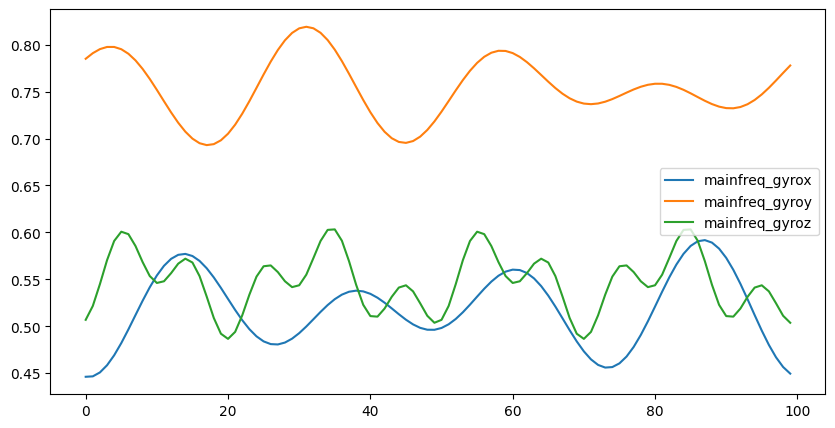

In [30]:
idx = 300
feature_id = 3
plt.figure(figsize=(10, 5))
plt.plot(x_m[idx,3,:], label='mainfreq_gyrox')
plt.plot(x_m[idx,4,:], label='mainfreq_gyroy')
plt.plot(x_m[idx,5,:], label='mainfreq_gyroz')

# plt.plot(x_r[idx,feature_id,:], label='Remaining')
# plt.plot(x_m[idx,feature_id,:], label='Main')
# plt.plot(input_tensor[idx,feature_id,:], label='Original')
# plt.plot(x_r[idx,feature_id,:] + x_m[idx,feature_id,:], label='Reconstructed')
plt.legend()
plt.show()

In [57]:
jumping_sample = jumping_data[1000:1100, :]
x_r, x_m = norm_and_main_freq(torch.tensor(jumping_sample).unsqueeze(0).float().permute(0,2,1), 5)
print(x_r.shape, x_m.shape)

check input shape torch.Size([1, 6, 100])
z shape torch.Size([1, 6, 51])
check top k indices torch.Size([1, 6, 5])
torch.Size([1, 6, 100]) torch.Size([1, 6, 100])


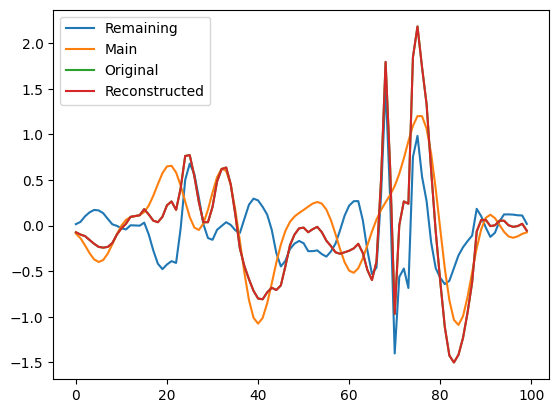

In [59]:
plt.plot(x_r[0,1,:], label='Remaining')
plt.plot(x_m[0,1,:], label='Main')
plt.plot(jumping_sample[:,1], label='Original')
plt.plot(x_r[0,1,:] + x_m[0,1,:], label='Reconstructed')
plt.legend()
plt.show()

In [1]:
import h5py
data_path_activity = '../Datas/uschad_activity_dataset.h5'
with h5py.File(data_path_activity, 'r') as f_r:
    dataset_genbylabel = f_r['datas']
    runningforward = dataset_genbylabel['jumping'][:]
print(runningforward.shape)

(107100, 6)


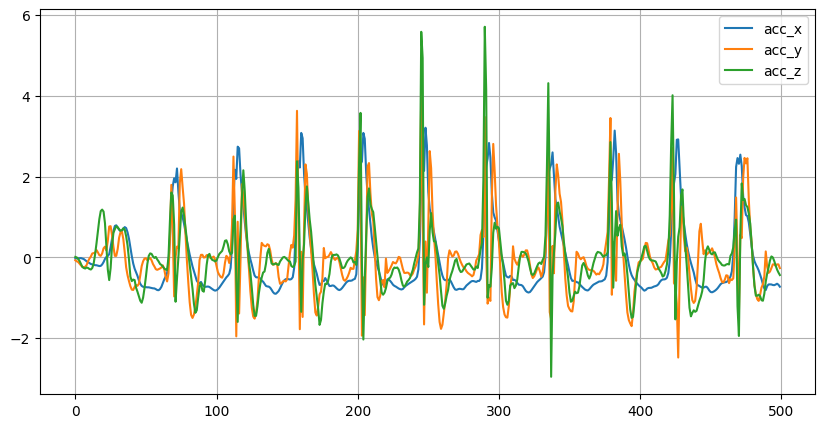

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
plt.plot(runningforward[1000:1500, 0], label='acc_x')
plt.plot(runningforward[1000:1500, 1], label='acc_y')
plt.plot(runningforward[1000:1500, 2], label='acc_z')
plt.legend()
plt.grid()
plt.show()

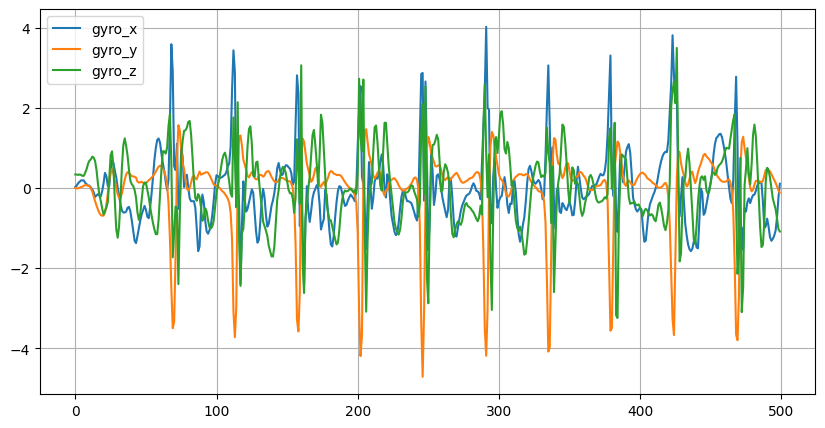

In [40]:
fig = plt.figure(figsize=(10, 5))
plt.plot(runningforward[1000:1500, 3], label='gyro_x')
plt.plot(runningforward[1000:1500, 4], label='gyro_y')
plt.plot(runningforward[1000:1500, 5], label='gyro_z')
plt.legend()
plt.grid()
plt.show()

In [33]:
from scipy.io import loadmat
mat_path = '../Datas/a2t2.mat'
mat_data = loadmat(mat_path)
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'title', 'version', 'date', 'subject', 'age', 'height', 'weight', 'activity', 'activity_number', 'trial', 'sensor_location', 'sensor_orientation', 'sensor_readings'])


In [34]:
print(mat_data['activity'])

['walking-left']


In [35]:
sensor = mat_data['sensor_readings']

In [36]:
sensor.shape

(2000, 6)

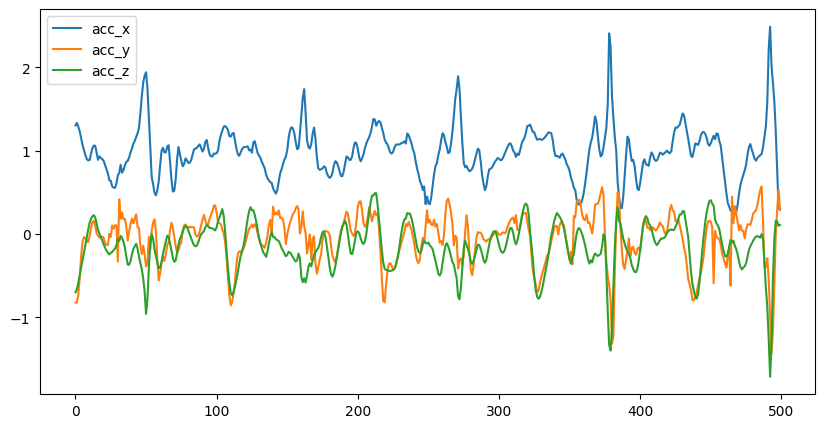

In [38]:
fig = plt.figure(figsize=(10, 5))
plt.plot(sensor[1000:1500, 0], label='acc_x')
plt.plot(sensor[1000:1500, 1], label='acc_y')
plt.plot(sensor[1000:1500, 2], label='acc_z')
# plt.plot(sensor[1000:1500, 3], label='gyro_x')
# plt.plot(sensor[1000:1500, 4], label='gyro_y')
# plt.plot(sensor[1000:1500, 5], label='gyro_z')
plt.legend()
plt.show()

In [5]:
import matplotlib.pyplot as plt
import torch

# Your norm_and_main_freq function to separate high and low frequencies
def norm_and_main_freq(x, k):
    print('check input shape', x.shape)
    # Apply FFT to get the frequency domain representation
    z = torch.fft.rfft(x, dim=2)
    
    # Find the top k largest magnitude frequency indices
    ks = torch.topk(z.abs(), k, dim=2)
    top_k_indices = ks.indices
    
    # Create a mask for the top k frequencies
    mask = torch.zeros_like(z)
    mask.scatter_(2, top_k_indices, 1)  # Set top k frequency indices to 1
    
    # Apply mask to get the top k frequency components
    z_m = z * mask  # z_m contains only the top k frequency components
    
    # Get the remaining frequencies (by zeroing out the top k components)
    z_r = z * (1 - mask)  # z_r contains the remaining lower magnitude frequencies
    
    # Apply inverse FFT to bring the signals back to time domain
    x_m = torch.fft.irfft(z_m, dim=2).real  # Main frequency components
    x_r = torch.fft.irfft(z_r, dim=2).real  # Remaining part (without top k frequencies)
    
    # Return both components
    return x_r, x_m

# Assuming runningforward is your original data in (n, 3) shape
# Convert runningforward to (1, n, 3) shape for the function
runningforward_tensor = torch.tensor(runningforward[:, :], dtype=torch.float32)
k = 5  # Number of main frequencies to keep
print(runningforward_tensor.shape)
# Get low-frequency (remaining) and high-frequency (main) components
x_r, x_m = norm_and_main_freq(runningforward_tensor, k)

# Convert tensors back to numpy arrays for plotting
x_r = x_r.squeeze().numpy()
x_m = x_m.squeeze().numpy()

# Plot the low-frequency part
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(x_r[1000:1500, 0], label='Low Freq - acc_x')
ax[0].plot(x_r[1000:1500, 1], label='Low Freq - acc_y')
ax[0].plot(x_r[1000:1500, 2], label='Low Freq - acc_z')
ax[0].legend()
ax[0].set_title("Low Frequency Components")
ax[0].grid()

# Plot the high-frequency part
ax[1].plot(x_m[1000:1500, 0], label='High Freq - acc_x')
ax[1].plot(x_m[1000:1500, 1], label='High Freq - acc_y')
ax[1].plot(x_m[1000:1500, 2], label='High Freq - acc_z')
ax[1].legend()
ax[1].set_title("High Frequency Components")
ax[1].grid()

plt.tight_layout()
plt.show()


torch.Size([107100, 6])
check input shape torch.Size([107100, 6])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

check activity shape walkingforward (1270, 300, 6)
check freq magnitude shape torch.Size([1270, 151])
check activity shape walkingleft (861, 300, 6)
check freq magnitude shape torch.Size([861, 151])
check activity shape walkingright (917, 300, 6)
check freq magnitude shape torch.Size([917, 151])
check activity shape walkingupstairs (705, 300, 6)
check freq magnitude shape torch.Size([705, 151])
check activity shape walkingdownstairs (657, 300, 6)
check freq magnitude shape torch.Size([657, 151])
check activity shape runningforward (587, 300, 6)
check freq magnitude shape torch.Size([587, 151])
check activity shape jumping (356, 300, 6)
check freq magnitude shape torch.Size([356, 151])
check activity shape sitting (870, 300, 6)
check freq magnitude shape torch.Size([870, 151])
check activity shape standing (785, 300, 6)
check freq magnitude shape torch.Size([785, 151])
check activity shape sleeping (1249, 300, 6)
check freq magnitude shape torch.Size([1249, 151])
check activity shape el

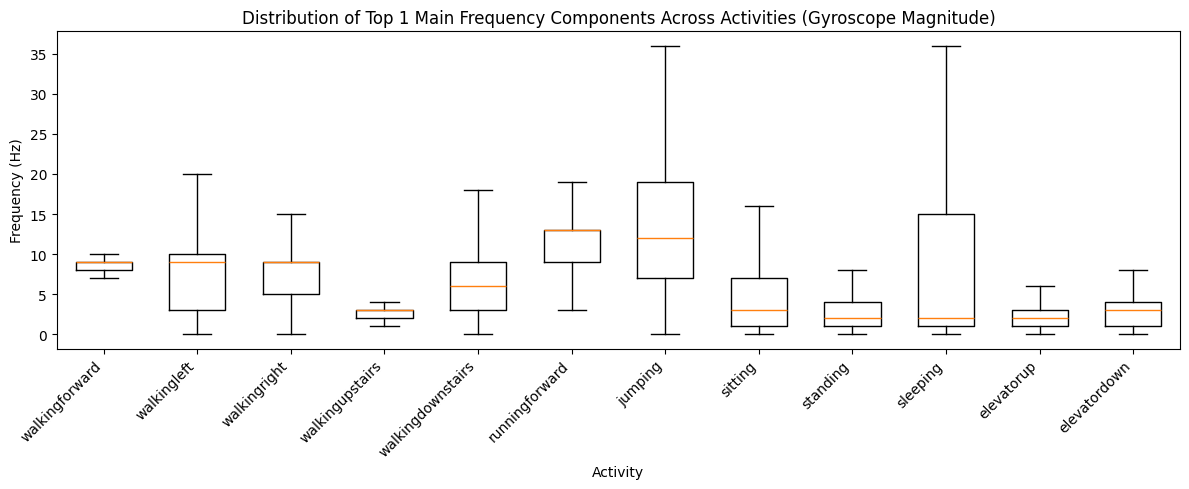

In [45]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler

def window_data(data, window):
    scaler = MinMaxScaler()
    data_fitted = scaler.fit_transform(data)
    window = 300

    num_splits = max((data_fitted.shape[0] - window + 1) // window, 0)
    data_all = []

    for i in range(num_splits):
        start = i * window
        end = (i + 1) * window
        data_all.append(data_fitted[start:end, :])
        
    data_all = np.array(data_all)
    return data_all

def calculate_main_frequencies(data, k=2):
    """
    Calculate the top-k main frequency components for each channel in the data.
    """

    data_tensor = torch.tensor(data, dtype=torch.float32)
    acc_data = data_tensor[:, :, 3:]  # Extract accelerometer data
    acc_magnitude = torch.sqrt((acc_data ** 2).sum(dim=2))  # Calculate magnitude of accelerometer data
    acc_magnitude = acc_magnitude - acc_magnitude.mean(dim=1, keepdim=True)
    
    hanning_window = torch.hann_window(acc_magnitude.shape[1]).to(acc_magnitude.device)
    acc_magnitude_windowed = acc_magnitude * hanning_window
    
    # Convert data to torch tensor for FFT
    # data_tensor = torch.tensor(data, dtype=torch.float32)
    
    # Apply FFT along the time dimension (dim=1)
    freq_data = torch.fft.rfft(acc_magnitude_windowed, dim=1)
    # Get the magnitude of each frequency component
    freq_magnitude = freq_data.abs()
    print('check freq magnitude shape', freq_magnitude.shape)
    # plt.plot(freq_magnitude[1400, :].cpu().numpy())
#     print(freq_magnitude)
    
#     # Identify the top-k frequencies for each channel
    top_k_freqs = torch.topk(freq_magnitude, k, dim=1).indices.cpu().numpy()
#     print(top_k_freqs)
    
    return top_k_freqs

# # Path to your dataset
data_path = '../Datas/uschad_activity_dataset.h5'
activity_label = {
    'walkingforward': 1,
    'walkingleft': 2,
    'walkingright': 3,
    'walkingupstairs': 4,
    'walkingdownstairs': 5,
    'runningforward': 6,
    'jumping': 7,
    'sitting': 8,
    'standing': 9,
    'sleeping': 10,
    'elevatorup': 11,
    'elevatordown': 12
}
# Dictionary to store main frequencies for each activity
activity_main_freqs = {}

# Load each activity's data and calculate main frequencies for each sample
with h5py.File(data_path, 'r') as f_r:
    for activity, label in activity_label.items():
        activity_data = f_r['datas'][activity][:]
        activity_data = window_data(activity_data, 100)
        print('check activity shape', activity, activity_data.shape)
        
        main_freqs = calculate_main_frequencies(activity_data, k=1)  # Shape: (n, k, 6)
        # Reshape main frequencies for easier plotting in boxplot
        main_freqs_flattened = main_freqs.flatten()
        # print('main freqs flattened shape',main_freqs_flattened.shape)
        # Store flattened main frequencies for each activity
        activity_main_freqs[activity] = main_freqs_flattened

# Plotting the main frequencies for each activity as a box plot
fig, ax = plt.subplots(figsize=(12, 5))

# Prepare box plot data
box_data = [activity_main_freqs[activity] for activity in activity_label.keys()]
print(box_data)
ax.boxplot(box_data, widths=0.6, showfliers=False)

# Set axis labels and title
ax.set_xticks(range(1, len(activity_label) + 1))
ax.set_xticklabels(activity_label.keys(), rotation=45, ha="right")
ax.set_title("Distribution of Top 1 Main Frequency Components Across Activities (Gyroscope Magnitude)")
ax.set_xlabel("Activity")
ax.set_ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()
